<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/92_gamma_1_and_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬📉 Phase-Space & Stability Analysis of Gene Regulatory ODEs

**Overview:**  
Explore how a simple gene-regulatory 2D ODE system behaves under parameter sweeps. We add linear decay terms (γ₁, γ₂) and study sensitivity, bifurcations and chaos for very small α.

---

**Model Equations**  
\begin{cases}
\frac{dx}{dt} = \frac{K\,x^{1/α}}{b^{1/α} + x^{1/α}} \;-\; γ_1\,x,\\[6pt]
\frac{dy}{dt} = \frac{K\,y^{1/α}}{b^{1/α} + x^{1/α}} \;-\; γ_2\,x.
\end{cases}

**Fixed:**  
- b = 1.0, K = 1.0  
- Time: t∈[0, 0.05], N = 500 steps

**Parameters:**  
- α ∈ {1e-9, 1e-10, … , 1e-14}  
- γ₁, γ₂ ∈ [0, 1] in 0.5 increments  

**Solvers:**  
RK45, DOP853, BDF, Radau, RK23, plus a simple explicit-Euler “symplectic” stepper.

---

**What this notebook does:**  
1. **Phase portraits** for each (solver, α) combo, plotting trajectories from multiple decay coefficients.  
2. **Arrow glyphs** show flow direction along each curve.  
3. **Inline labels** (γ₁, γ₂) drawn at midpoints in matching colors.  
4. **Failure tracking**: records and plots which α produce NaN/Inf for each solver.  
5. **Lyapunov & bifurcation analysis** (optional cells): estimate largest Lyapunov exponent and detect Neimark–Sacker bifurcations via Poincaré map.

---

*Use this as a flexible framework to explore stability, bifurcation and chaotic regimes in gene regulatory ODEs.*


In [19]:
# Modified code for a gene regulatory system with phase space visualization
# exploring stability and bifurcation in gene regulation ODE system

# Cell 1: Parameters and library imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle
import time
from matplotlib import cm
from numpy.linalg import eigvals

b = 1.0
#t_end = 0.05
t_end = 1
K = 1.0
# alpha_list = [1e-4 * (10 ** -i) for i in range(10)]  # 1e-4 to 1e-13
alpha_list = [1e-9 * (10 ** -i) for i in range(6)]  # 1e-9 to 1e-14
#alpha_list = [1e-9 * (10 ** -i) for i in range(9)]  # 1e-9 to 1e-17

N = 500
t_eval = np.linspace(0, t_end, N)
initial_shifts = [-1e-3, -1e-6, 0.0, 1e-6, 1e-3]

print("Alpha values:", alpha_list)

MAX_LOG_MESSAGES = 3
all_methods = ["RK45", "DOP853", "BDF", "Radau", "RK23", "Symplectic"]
error_counts = {m: 0 for m in all_methods}
error_counts.update({m + '_msgs': 0 for m in all_methods})
alpha_failed = {m: [] for m in all_methods}

# positive gamma only
gamma_1_list = np.arange(0, 1.1, 0.5)
gamma_2_list = np.arange(0, 1.1, 0.5)

style_map = {}

# Grouped styles for gamma2 categories
group_styles = {
    'zero': {'color': 'tab:blue', 'linestyle': '-'},      # gamma2 == 0
    'half': {'color': 'tab:orange', 'linestyle': '--'},   # gamma2 == 0.5
    'one': {'color': 'tab:green', 'linestyle': ':'}       # gamma2 == 1.0
}

Alpha values: [1e-09, 1.0000000000000002e-10, 1.0000000000000001e-11, 1.0000000000000002e-12, 1.0000000000000002e-13, 1.0000000000000002e-14]


In [20]:
# Cell 2: Define RHS with decay terms
def get_rhs_system(alpha, K, gamma1, gamma2):
    eps = alpha * 10
    x0 = b * (1 - eps)
    y0 = b * (1 - eps)

    def rhs(t, xy):
        x_safe = np.clip(xy[0], 1e-20, 1e20)
        y_safe = np.clip(xy[1], 1e-20, 1e20)
        inv_alpha = 1 / alpha
        exp_x = np.exp(np.clip(np.log(x_safe) * inv_alpha, -700, 700))
        exp_y = np.exp(np.clip(np.log(y_safe) * inv_alpha, -700, 700))
        exp_b = np.exp(np.clip(np.log(b) * inv_alpha, -700, 700))
        denom = exp_b + exp_x
        dxdt = K * exp_x / denom - gamma1 * x_safe
        dydt = K * exp_y / denom - gamma2 * x_safe
        return [dxdt, dydt]

    return rhs, x0, y0

Method: RK45


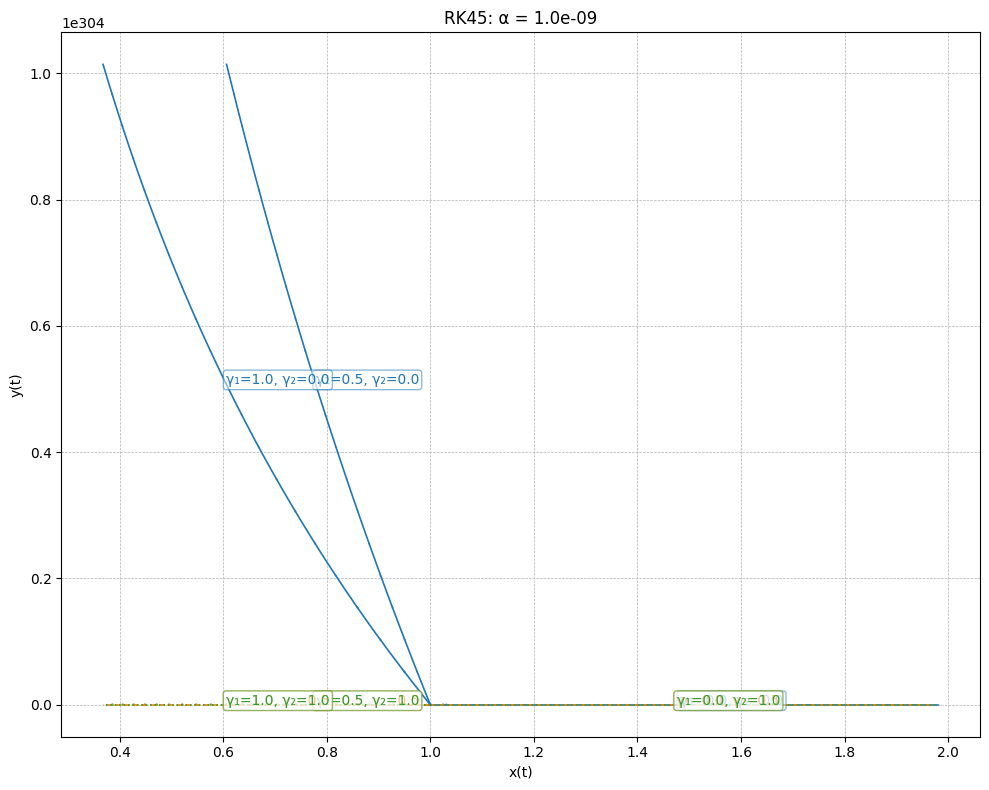

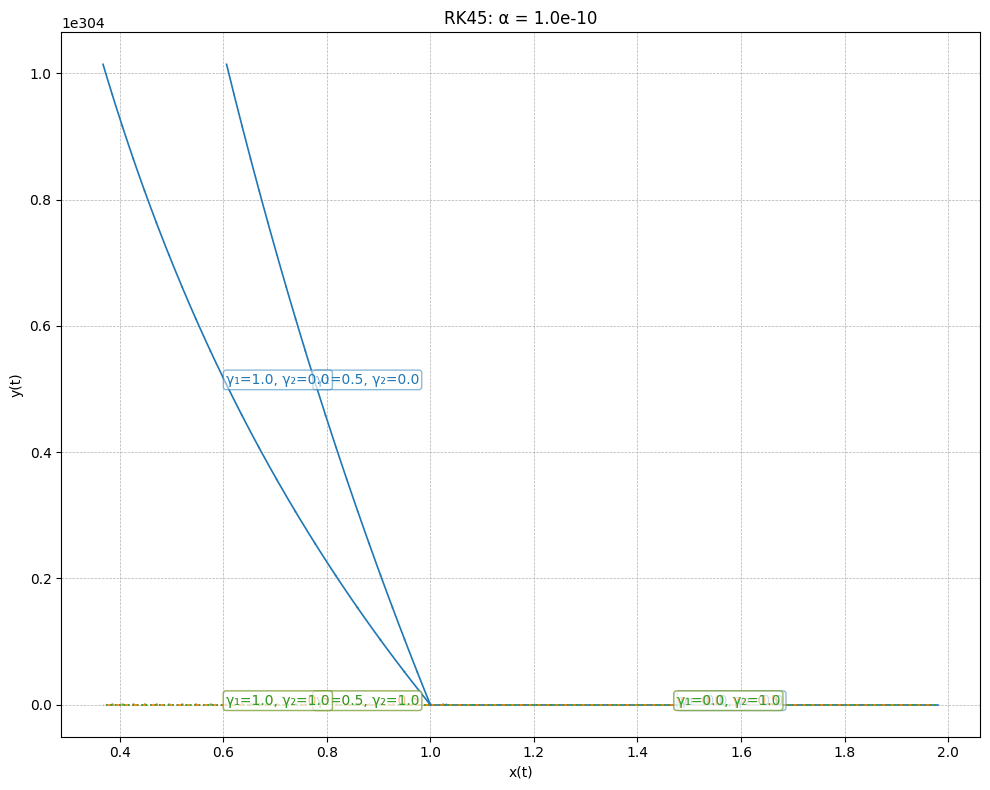

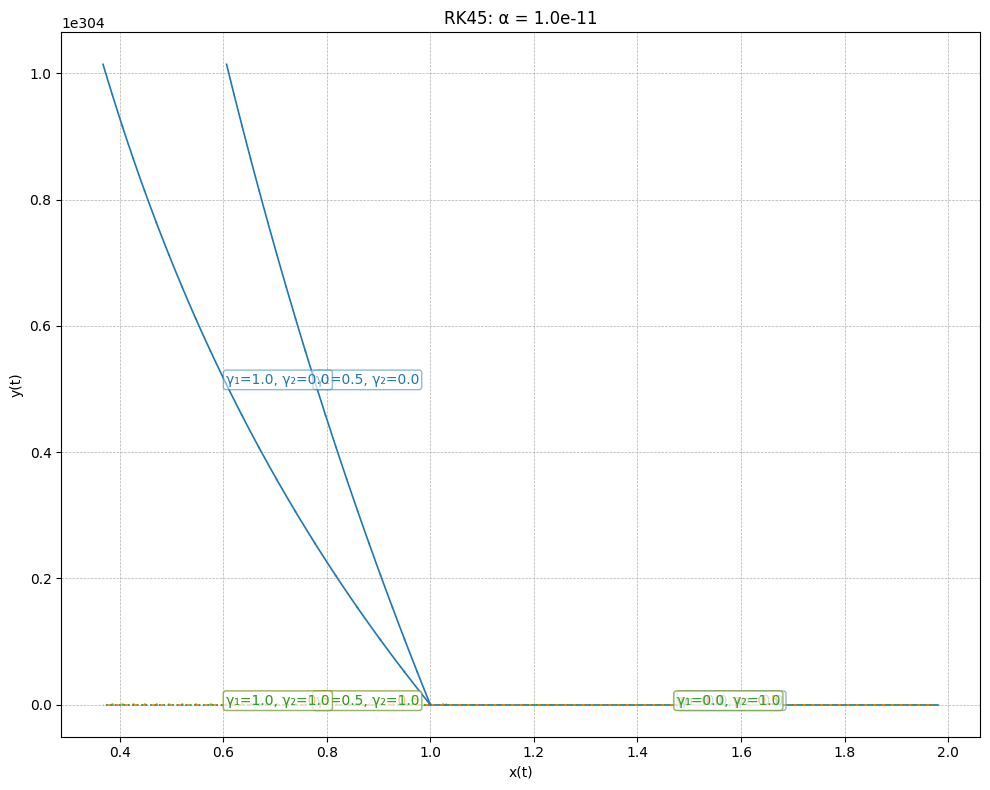

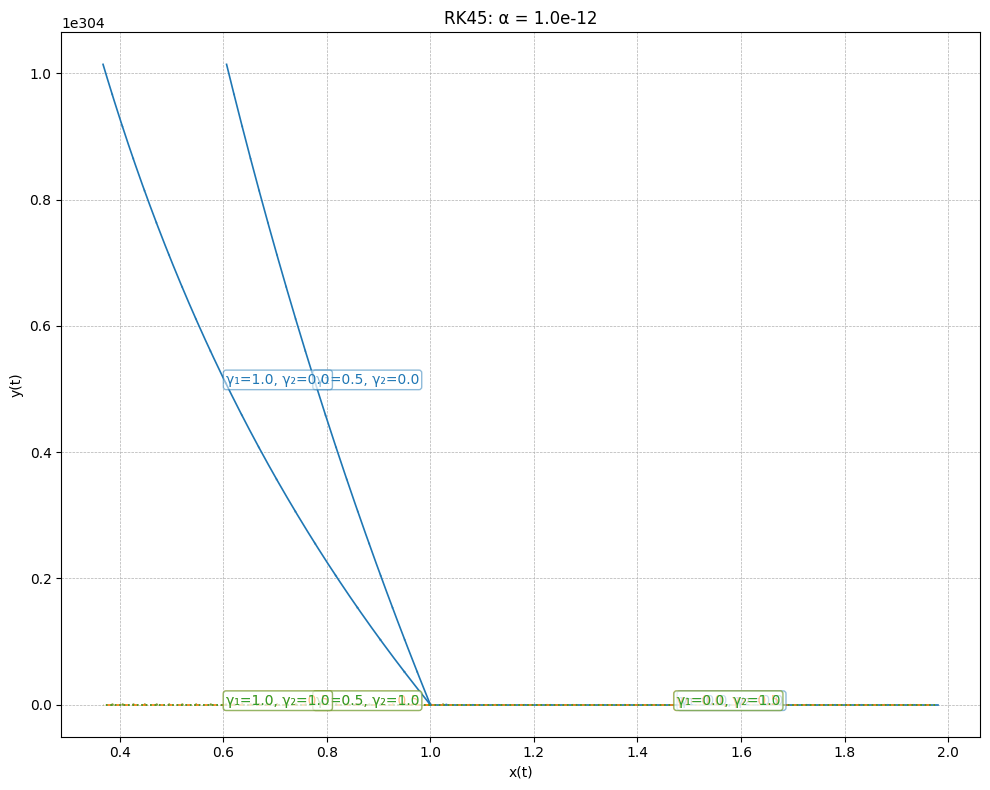

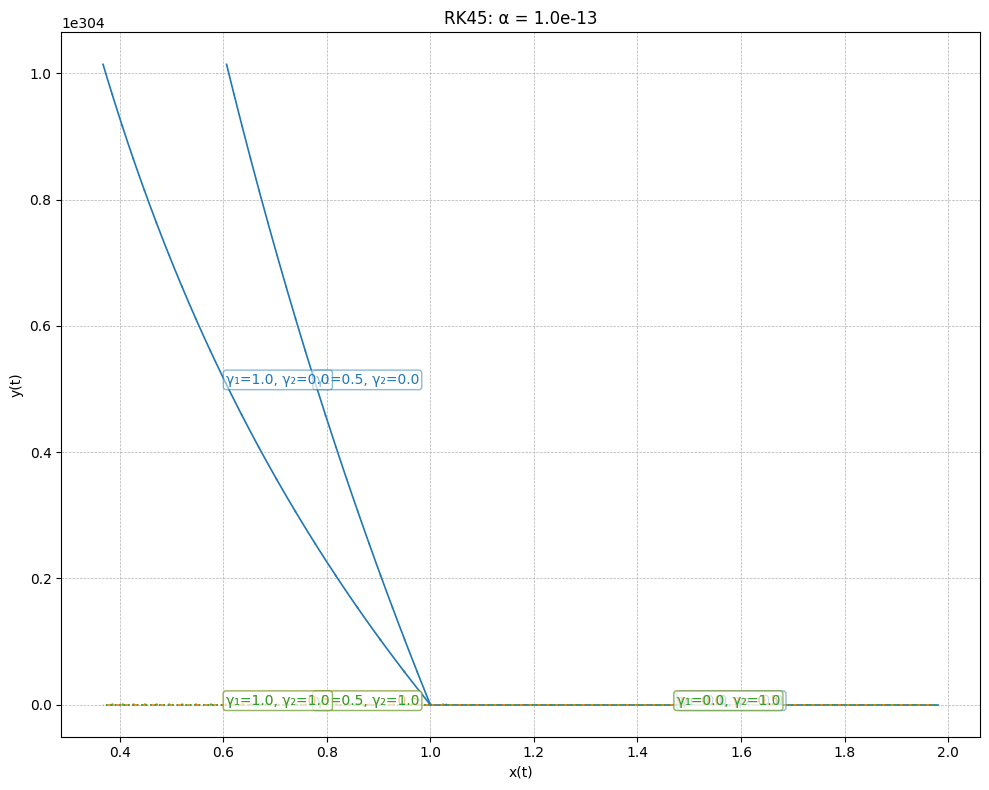

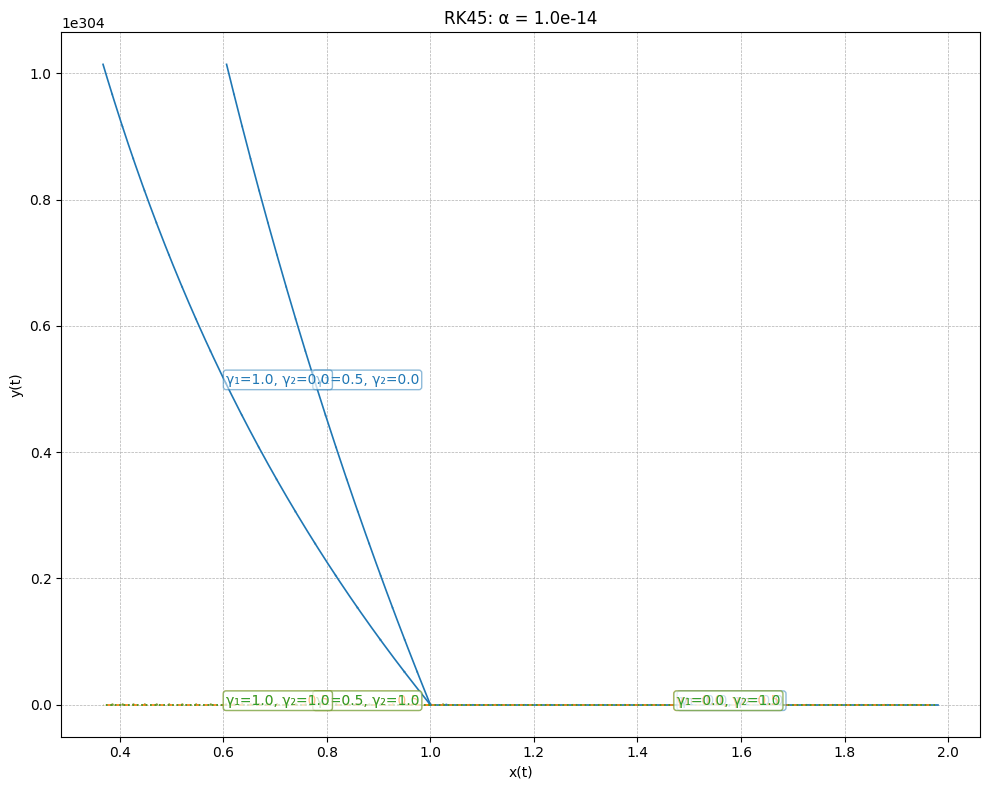

Method: DOP853


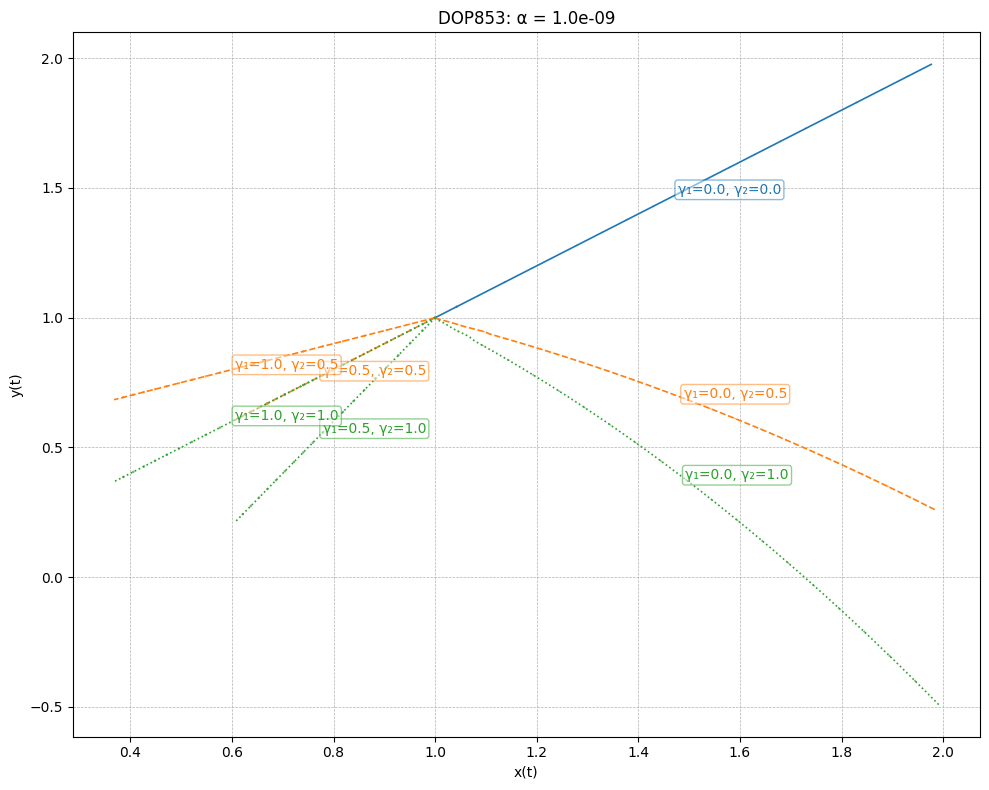

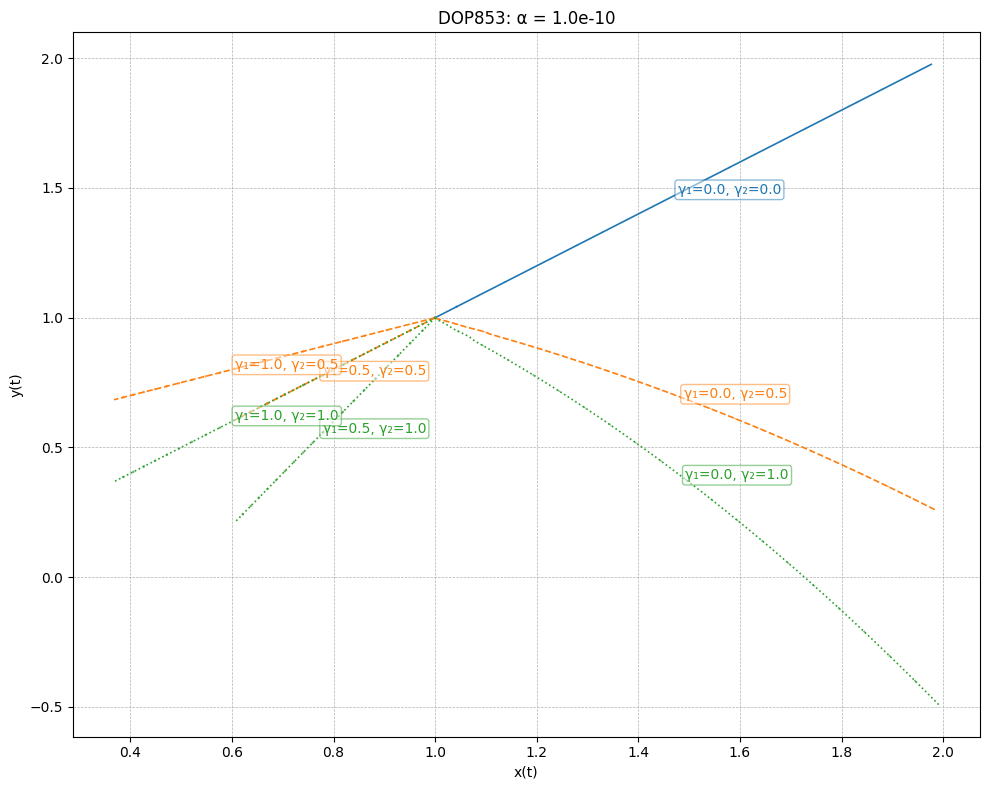

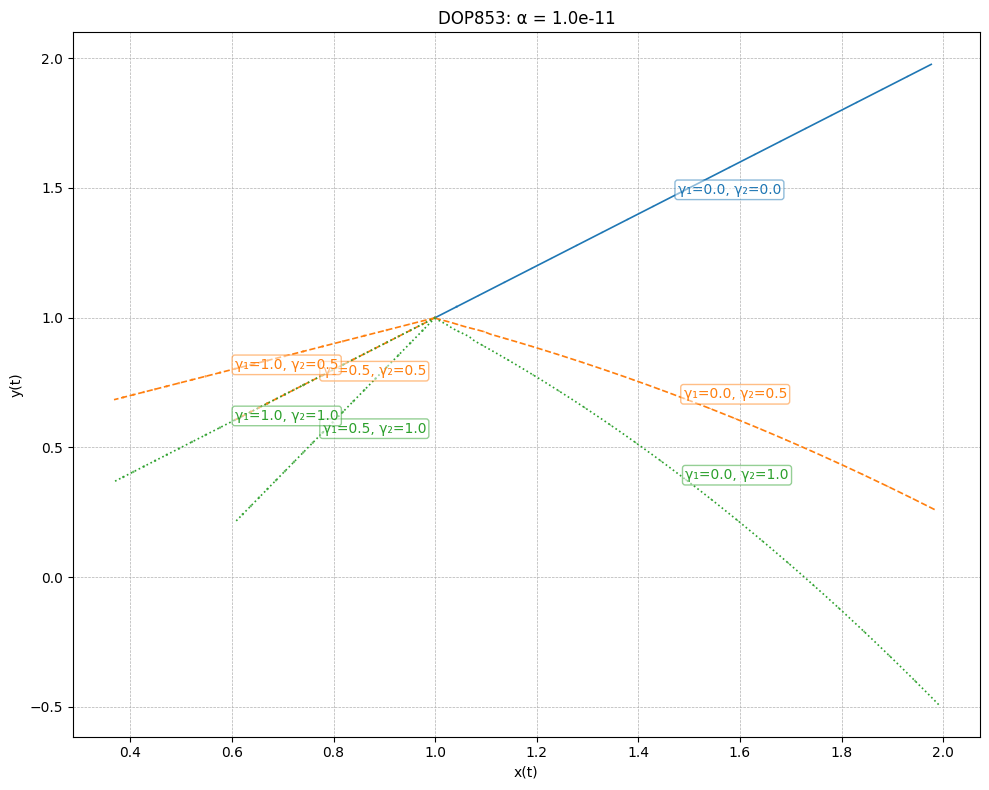

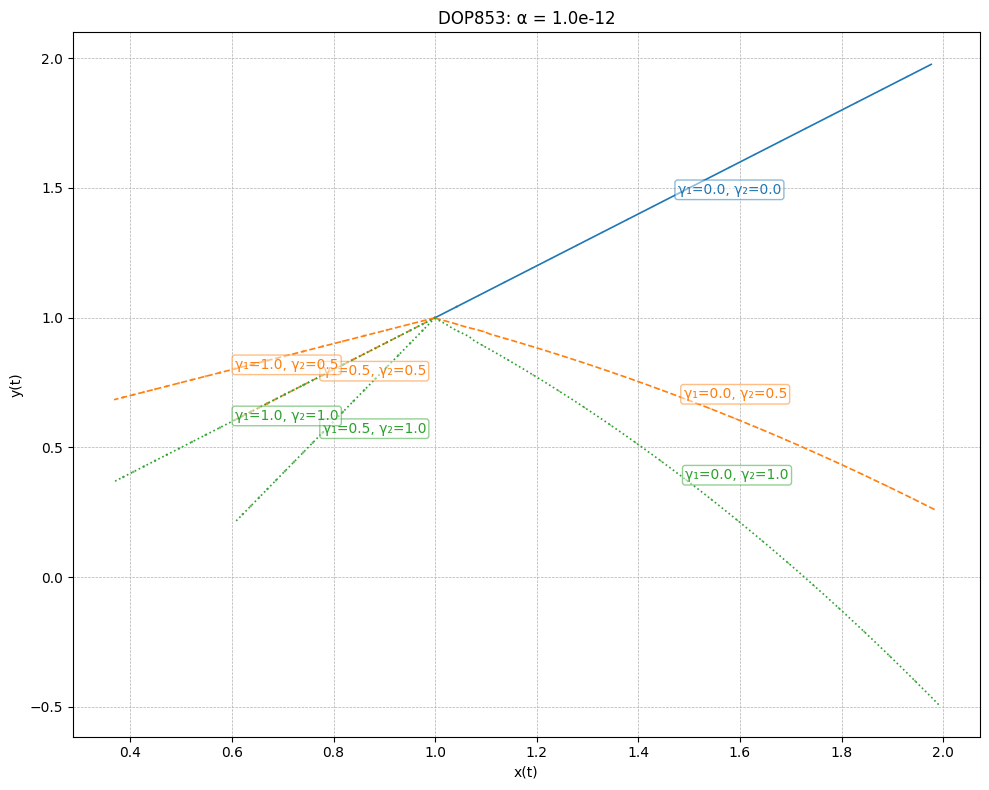

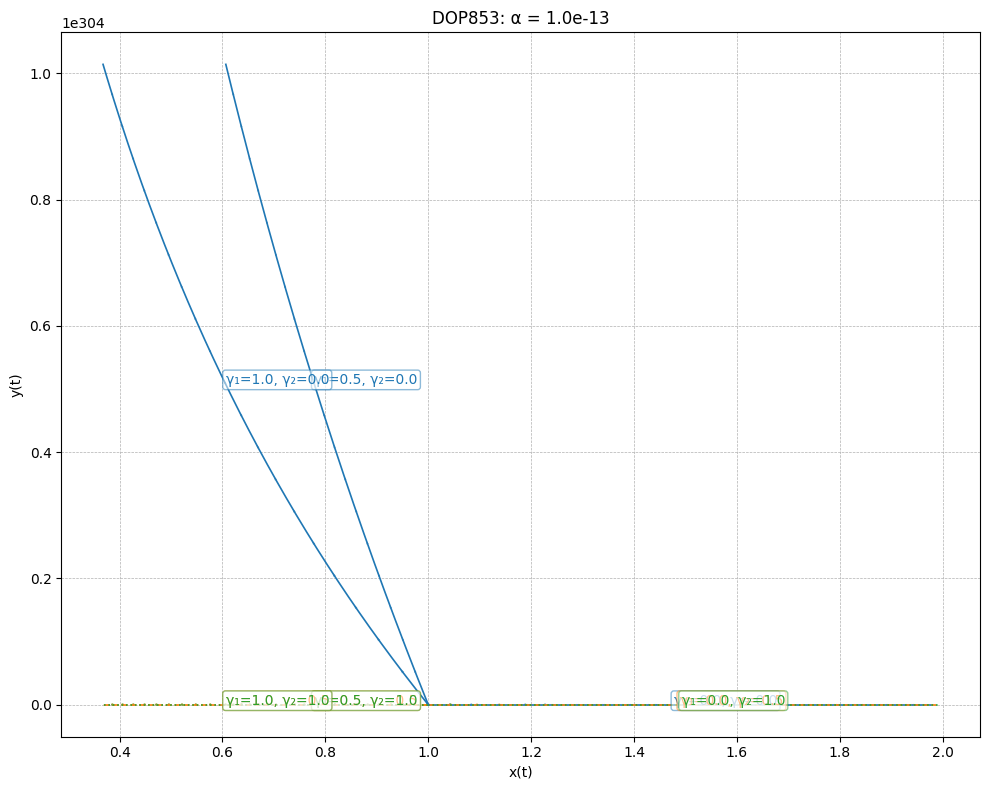

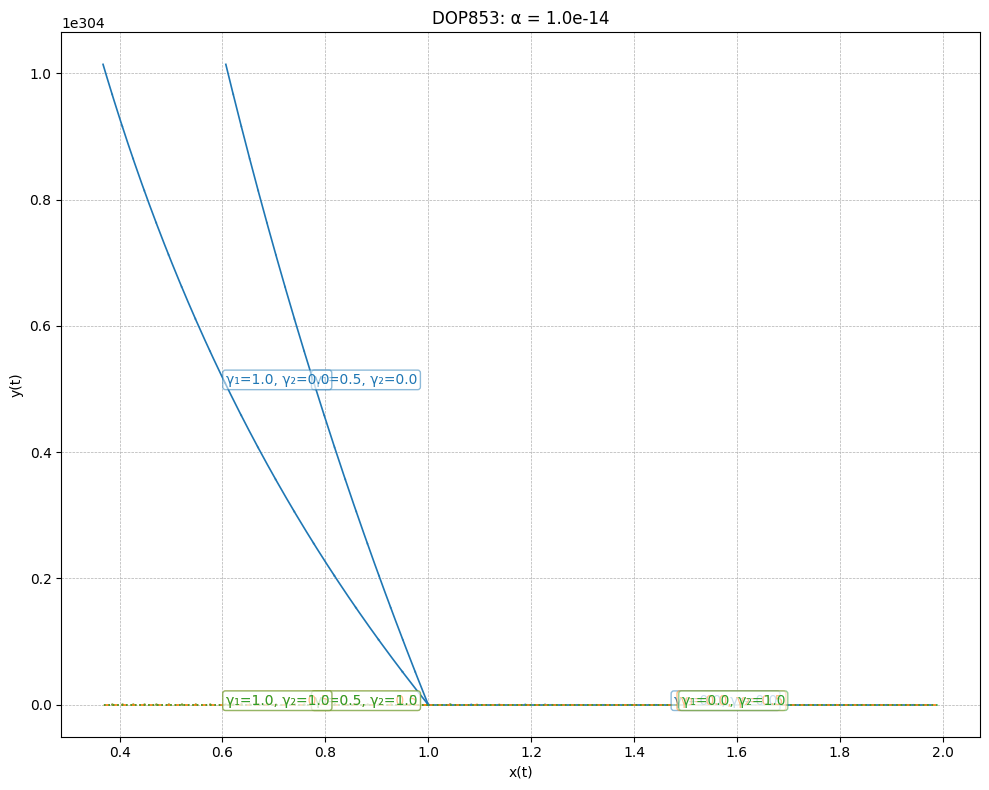

Method: BDF


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/bdf.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  change_D(D, self.order, min_step / self.h_abs)


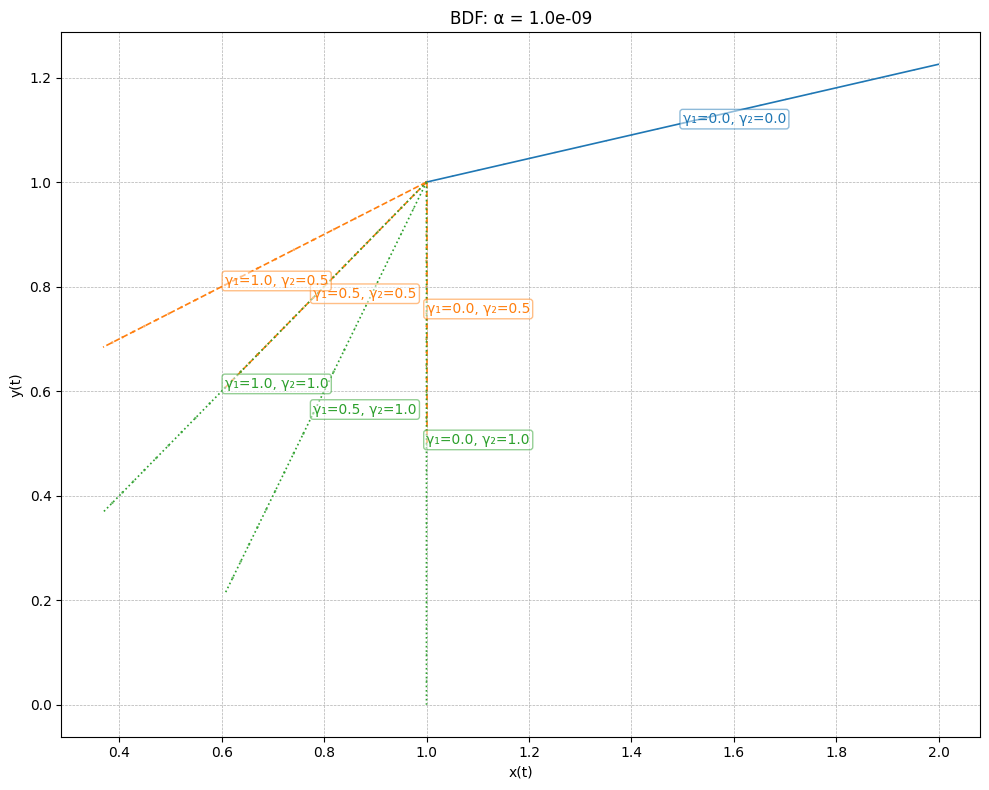

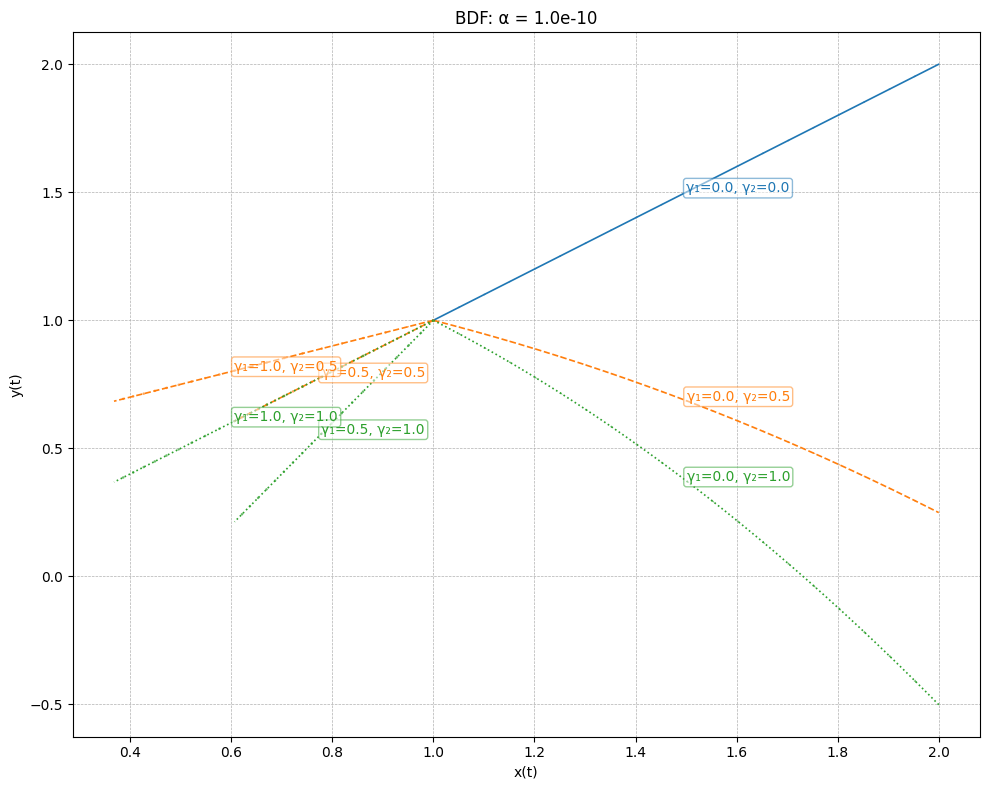

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/common.py:376: RuntimeWarning: overflow encountered in divide
  diff /= h


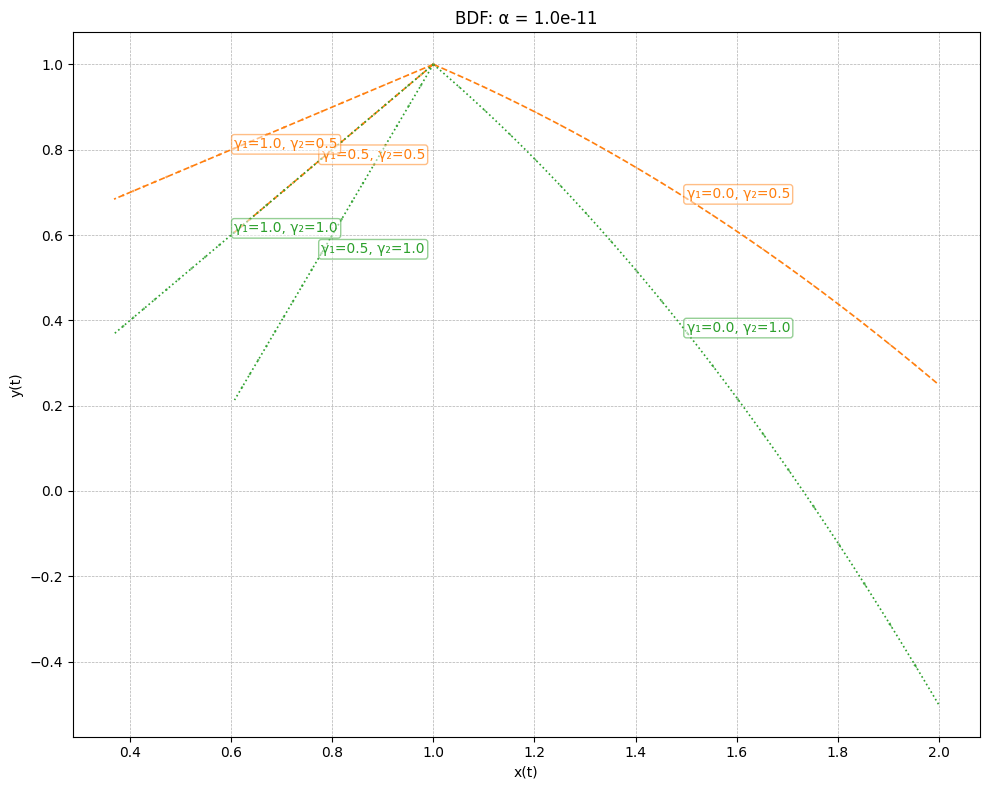

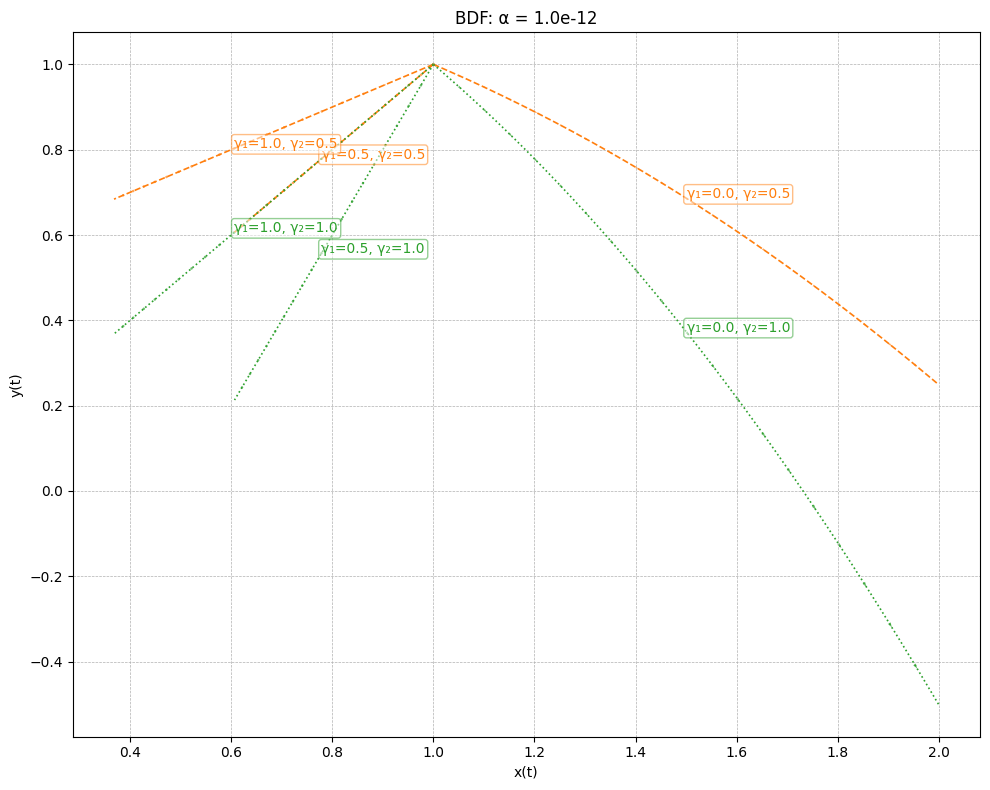

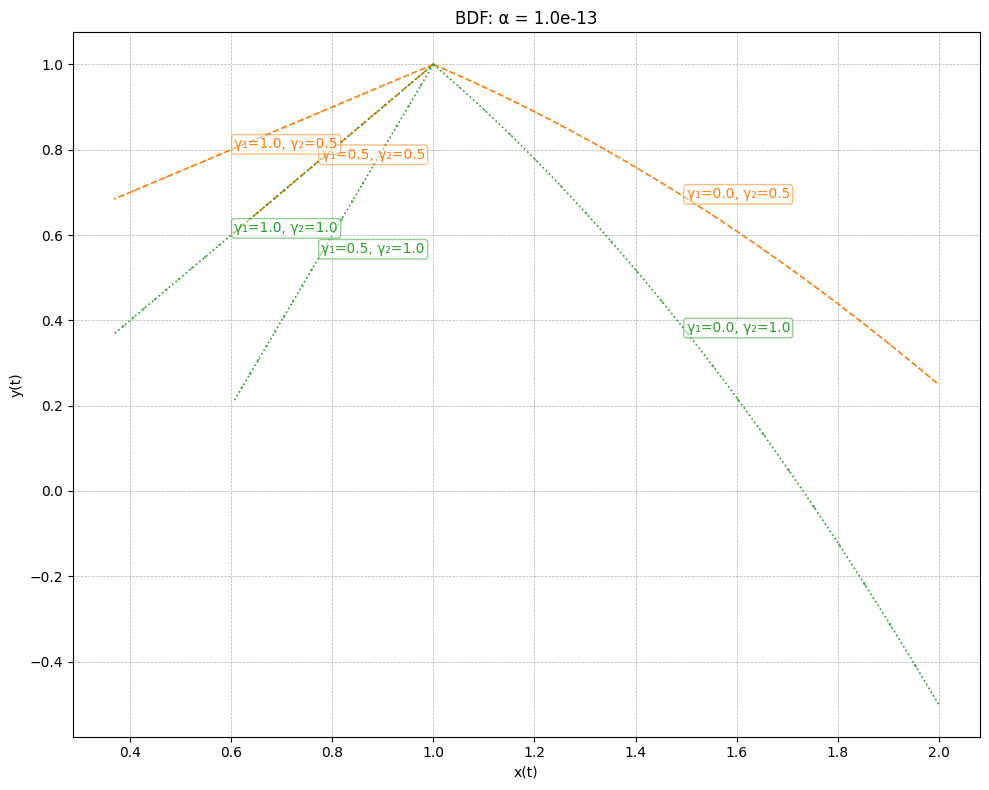

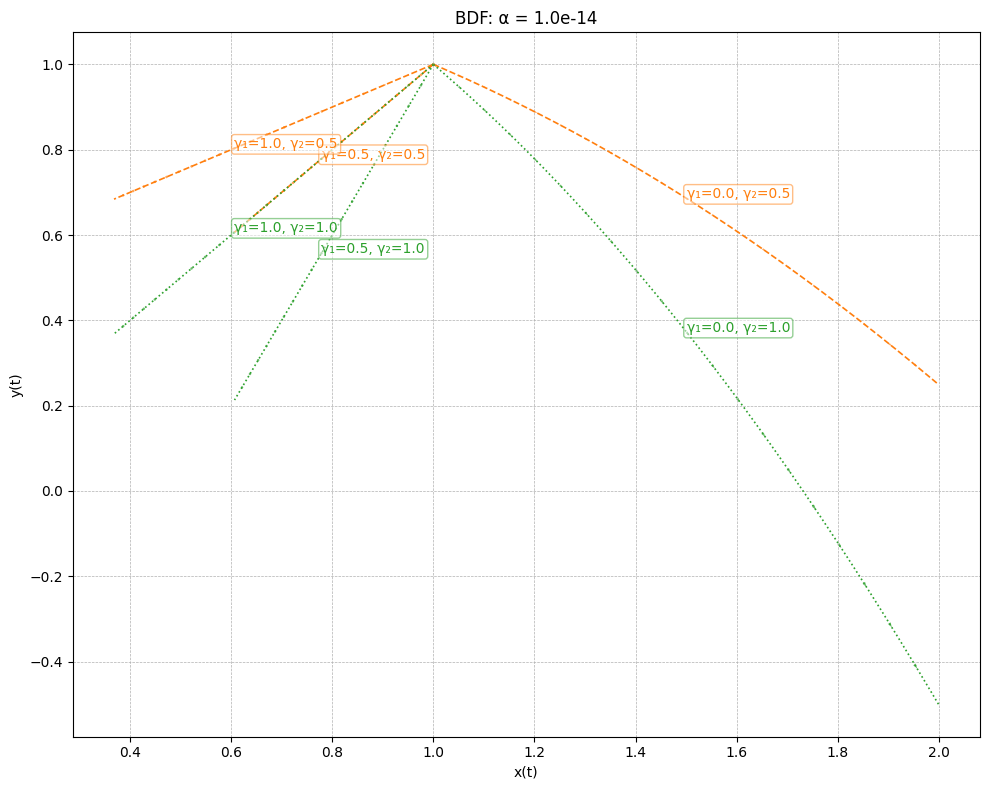

Method: Radau


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/radau.py:120: RuntimeWarning: invalid value encountered in scalar divide
  rate = dW_norm / dW_norm_old
/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/radau.py:455: RuntimeWarning: overflow encountered in scalar divide
  LU_real = self.lu(MU_REAL / h * self.I - J)
/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/radau.py:455: RuntimeWarning: invalid value encountered in multiply
  LU_real = self.lu(MU_REAL / h * self.I - J)


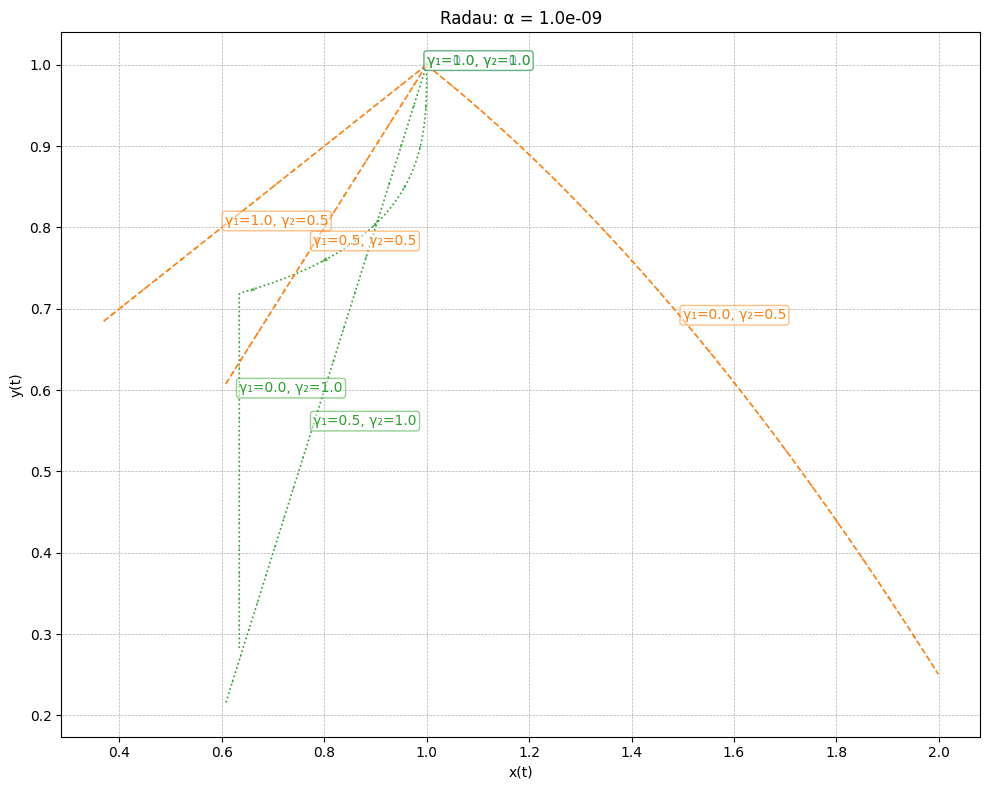

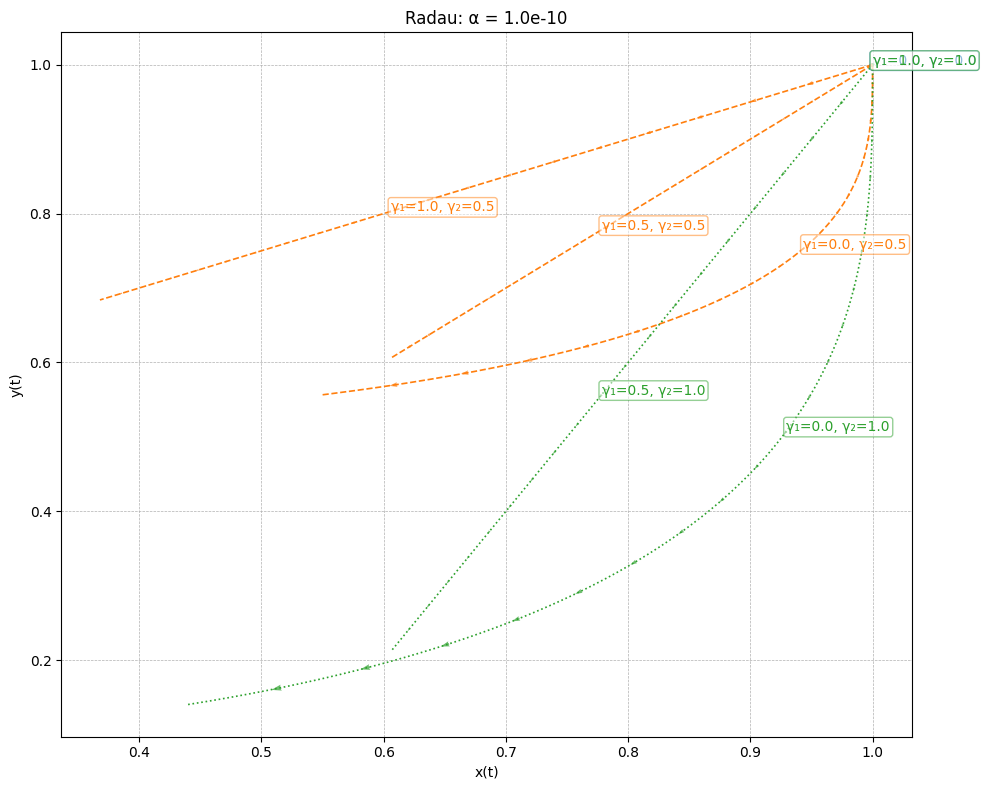

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/radau.py:455: RuntimeWarning: invalid value encountered in subtract
  LU_real = self.lu(MU_REAL / h * self.I - J)


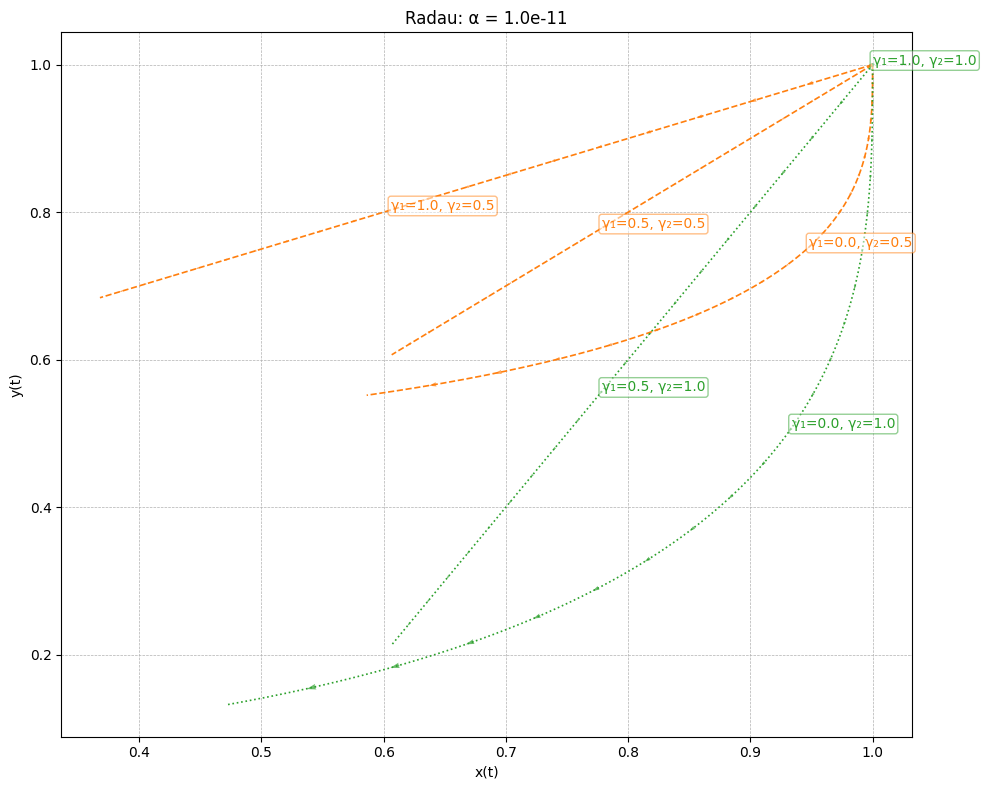

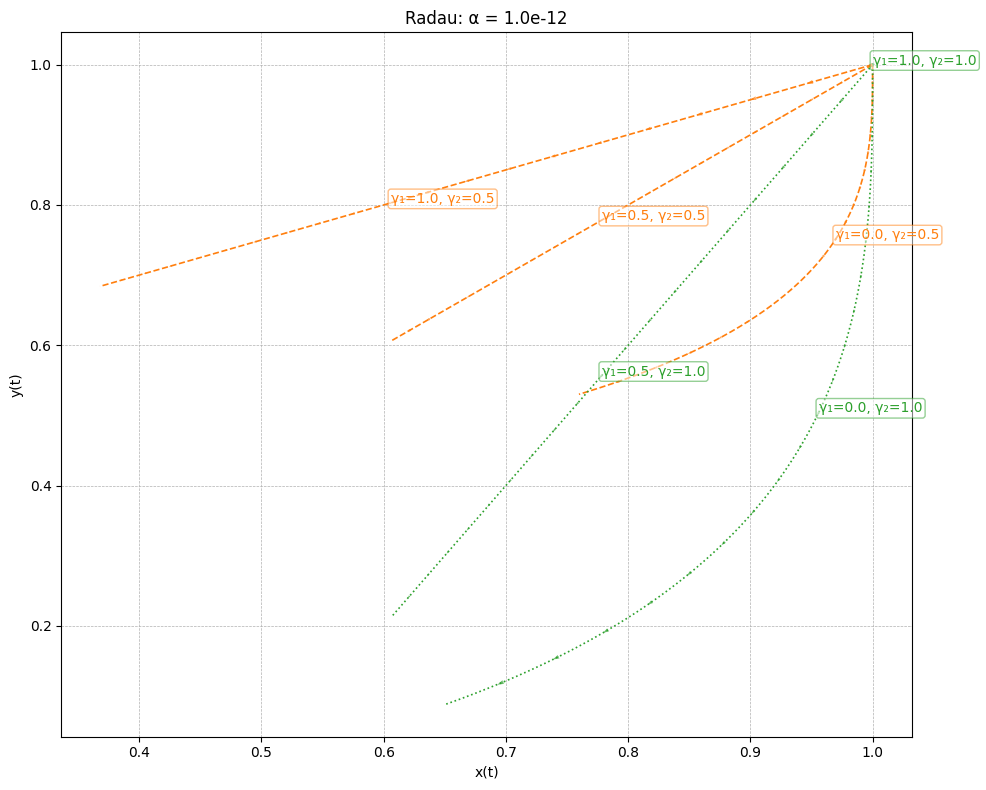

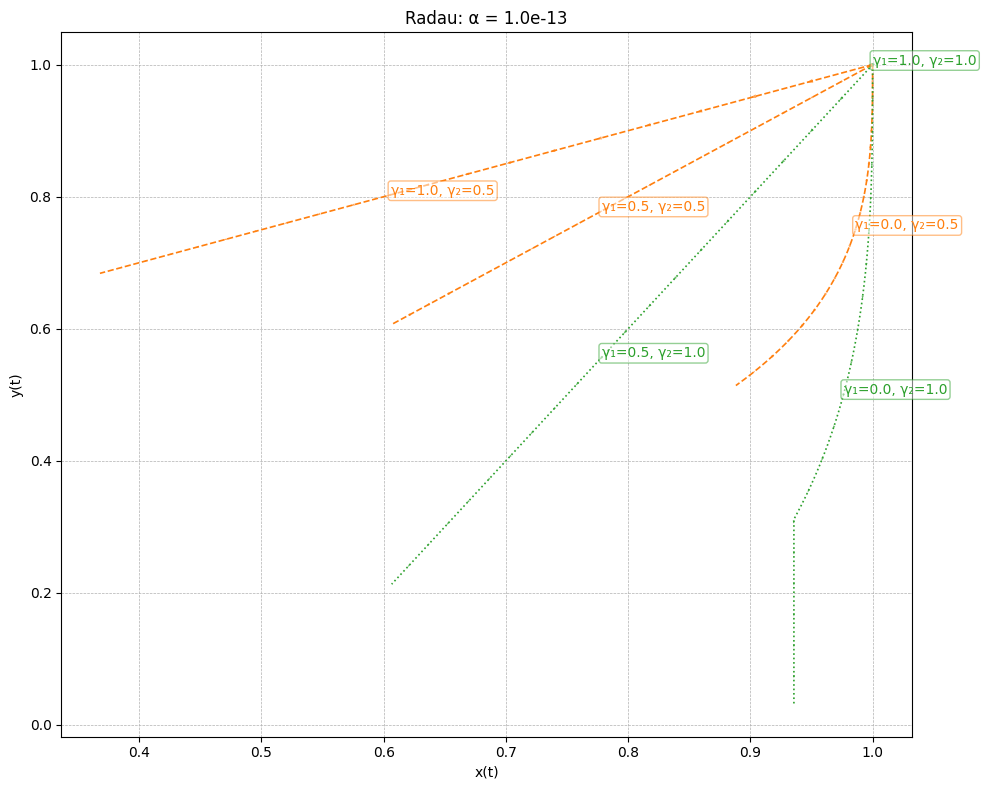

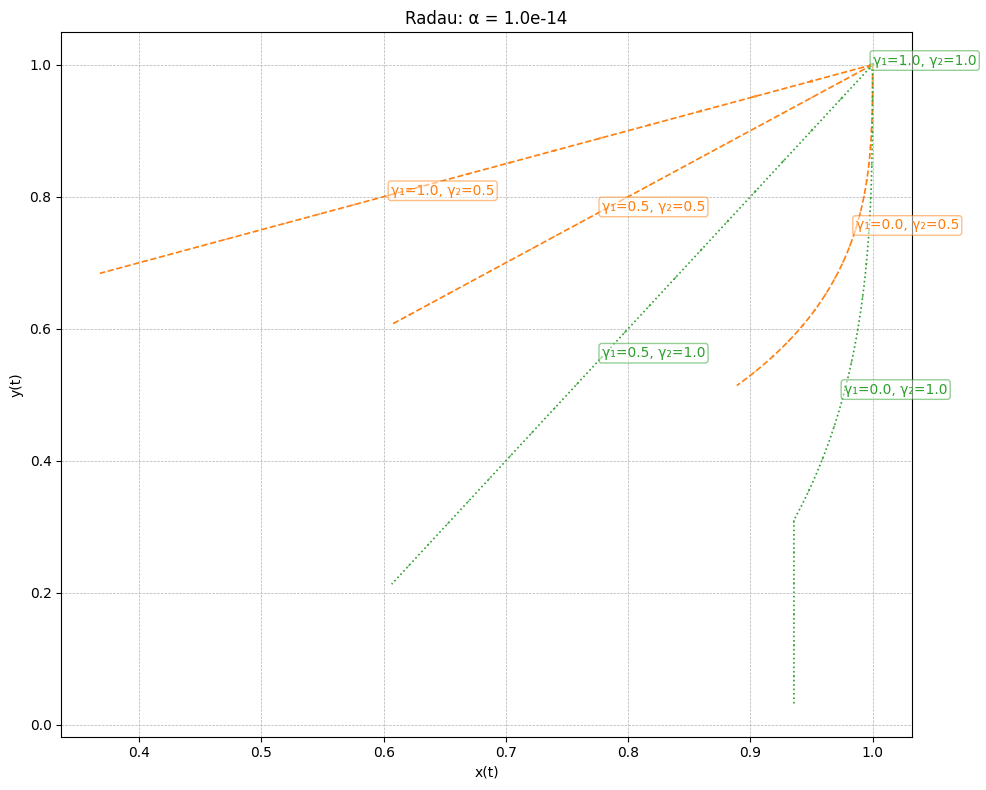

Method: RK23


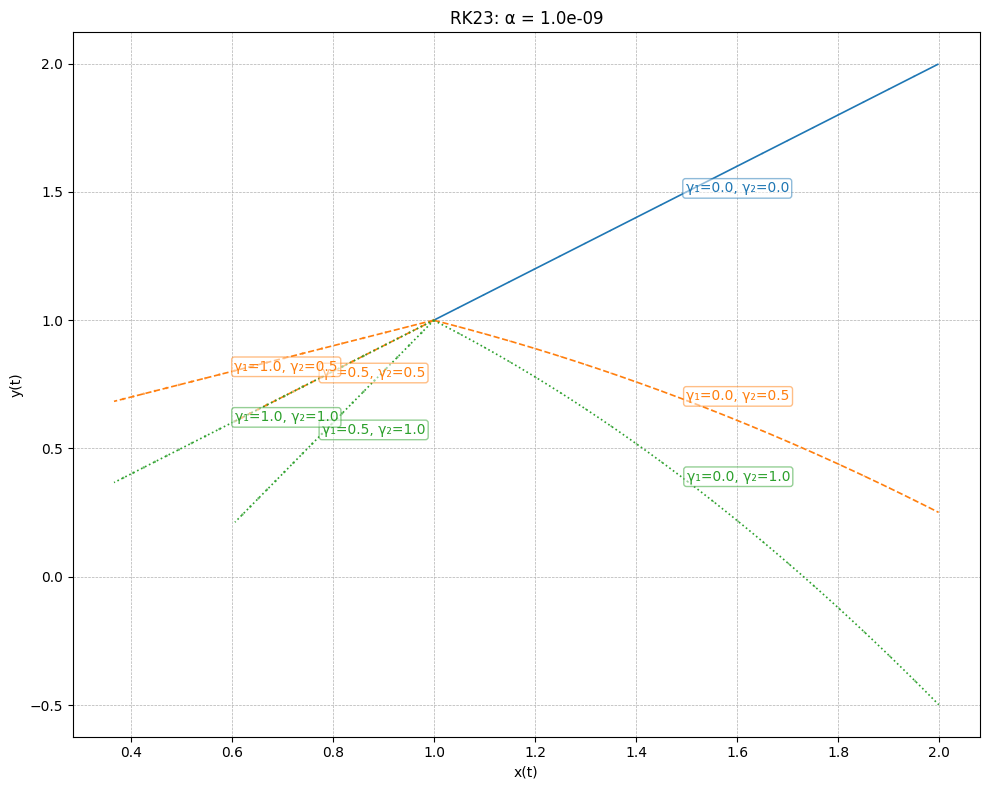

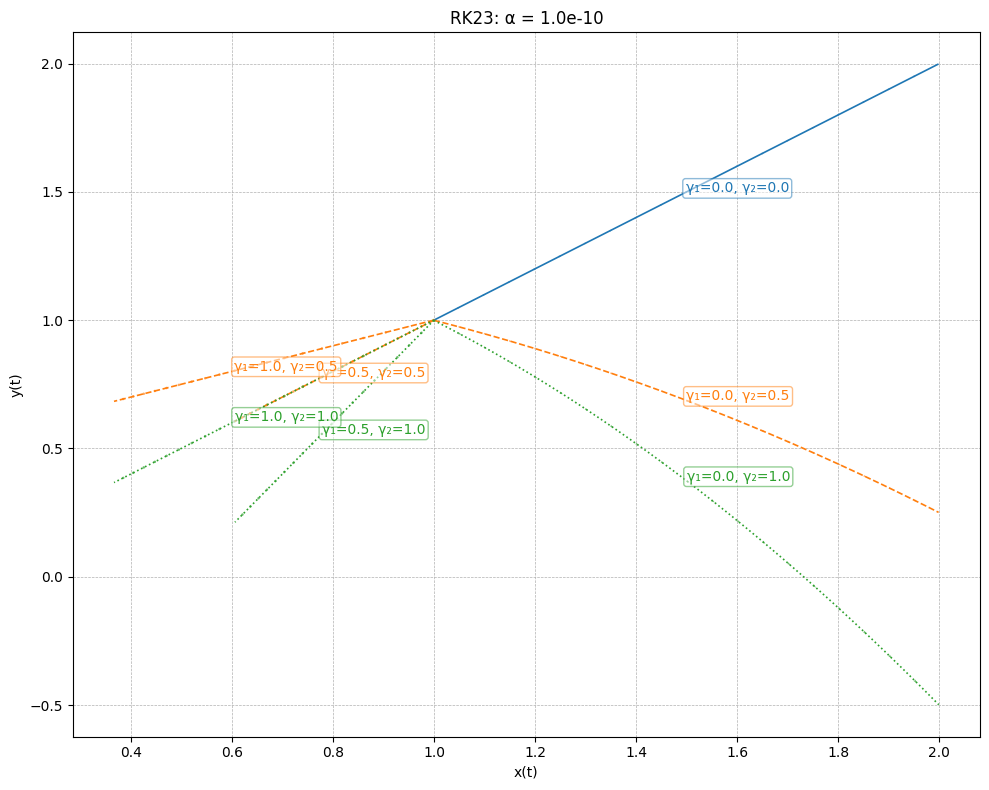

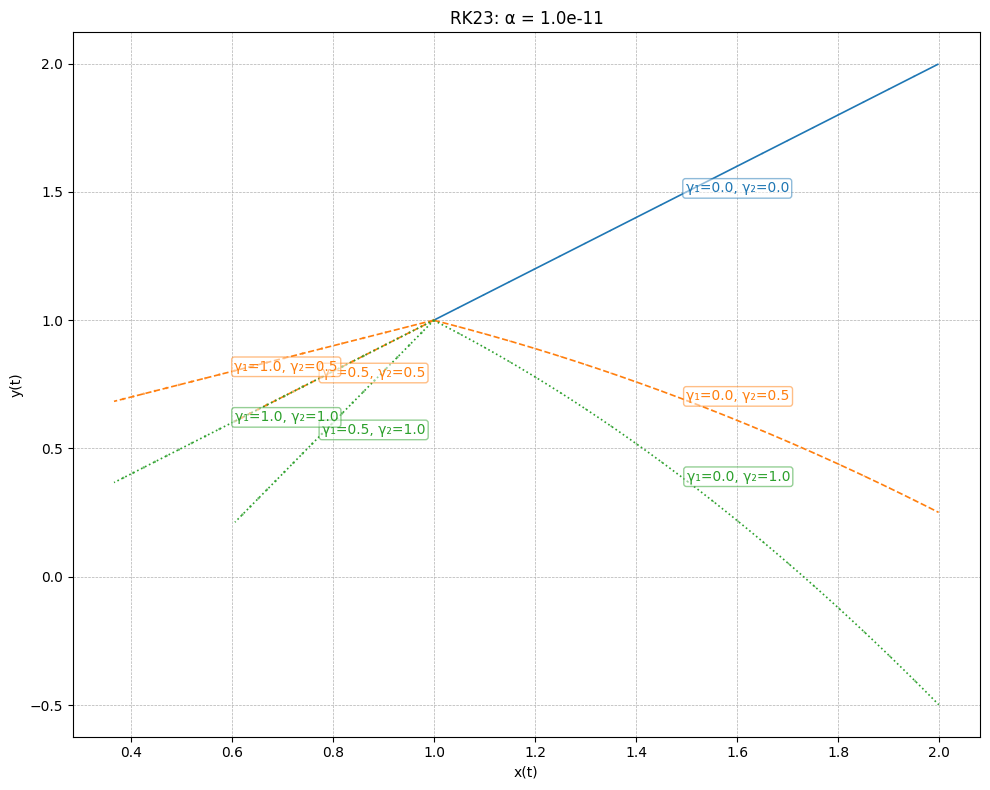

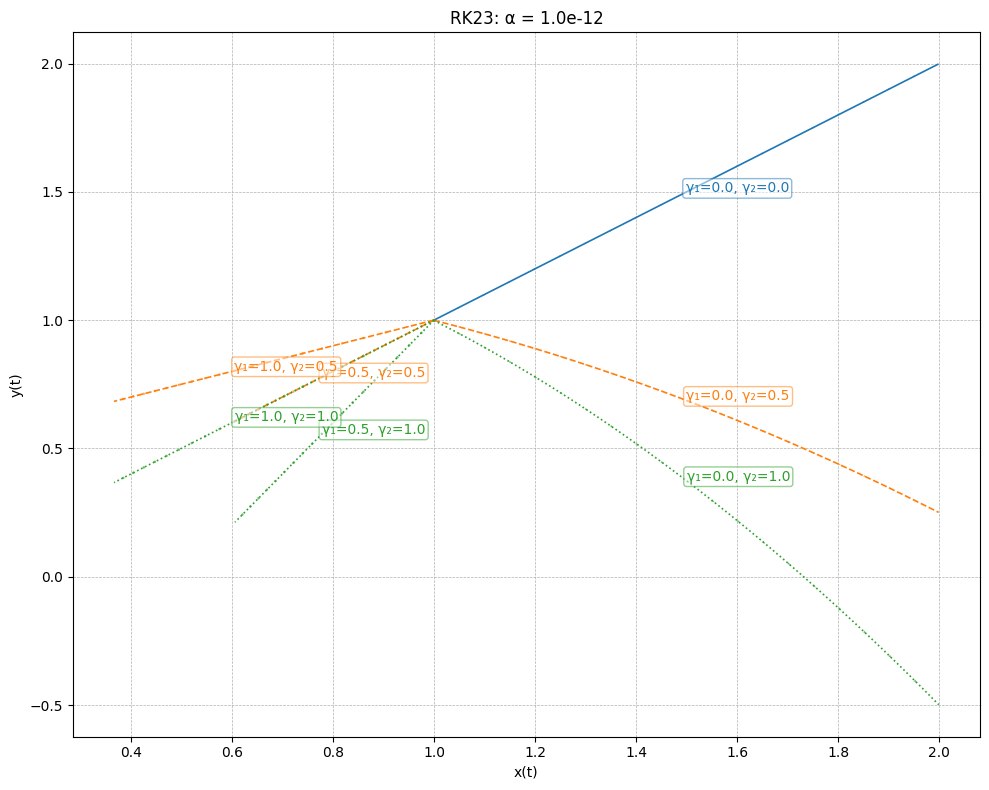

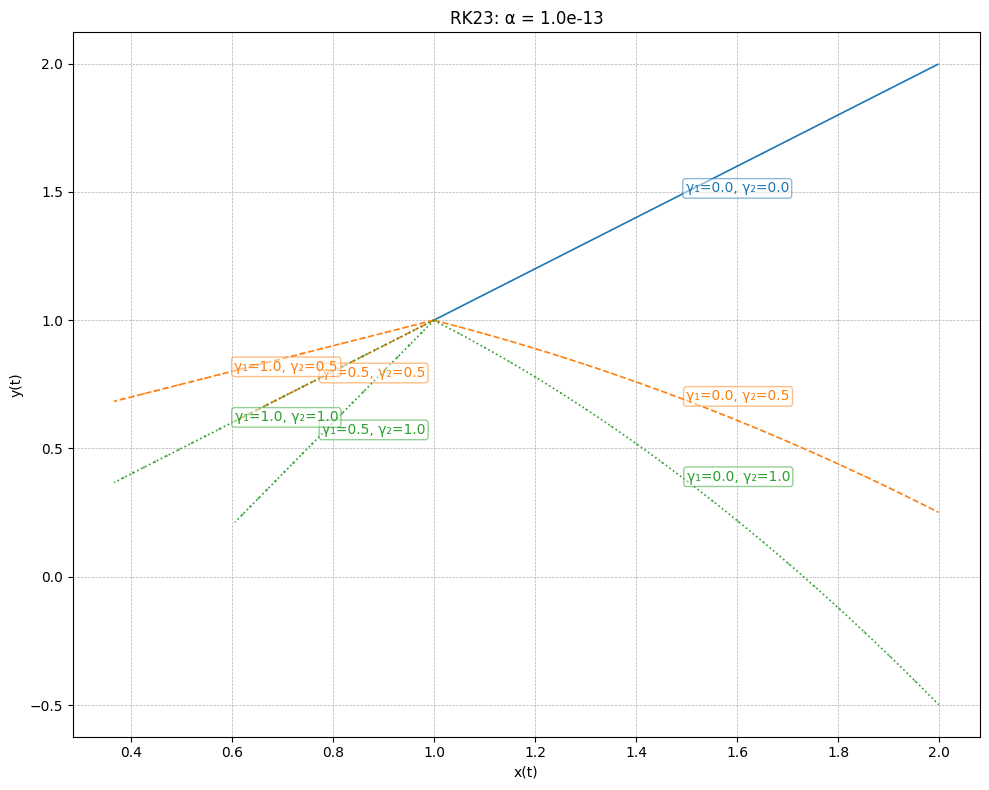

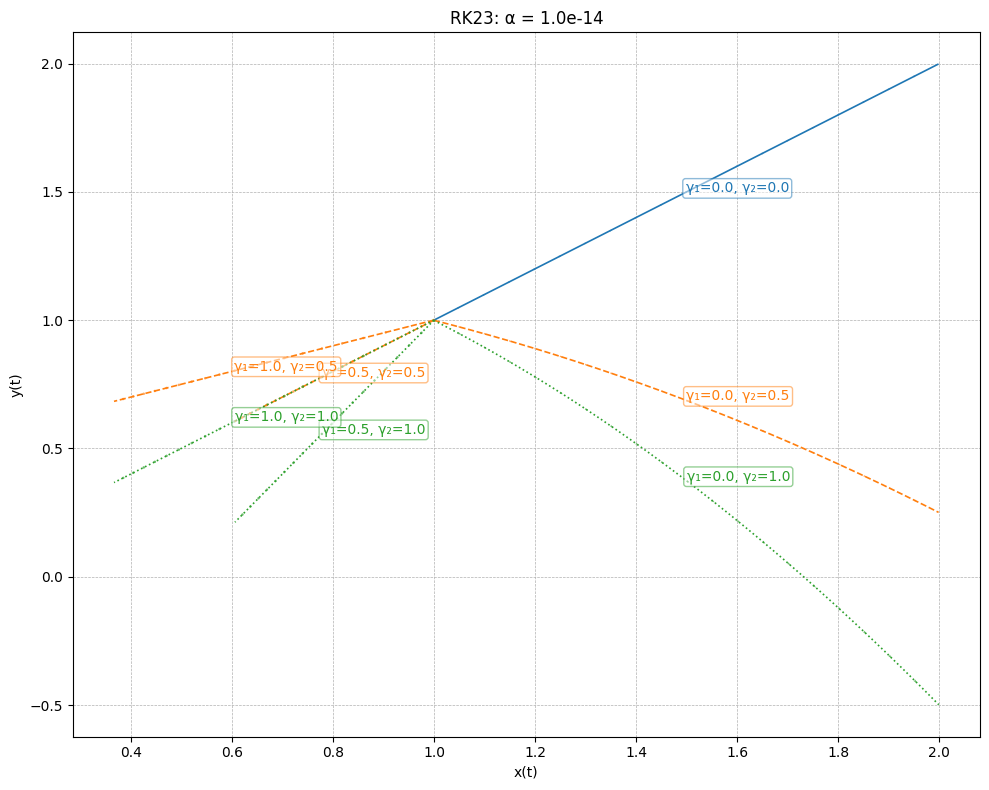

Method: Symplectic


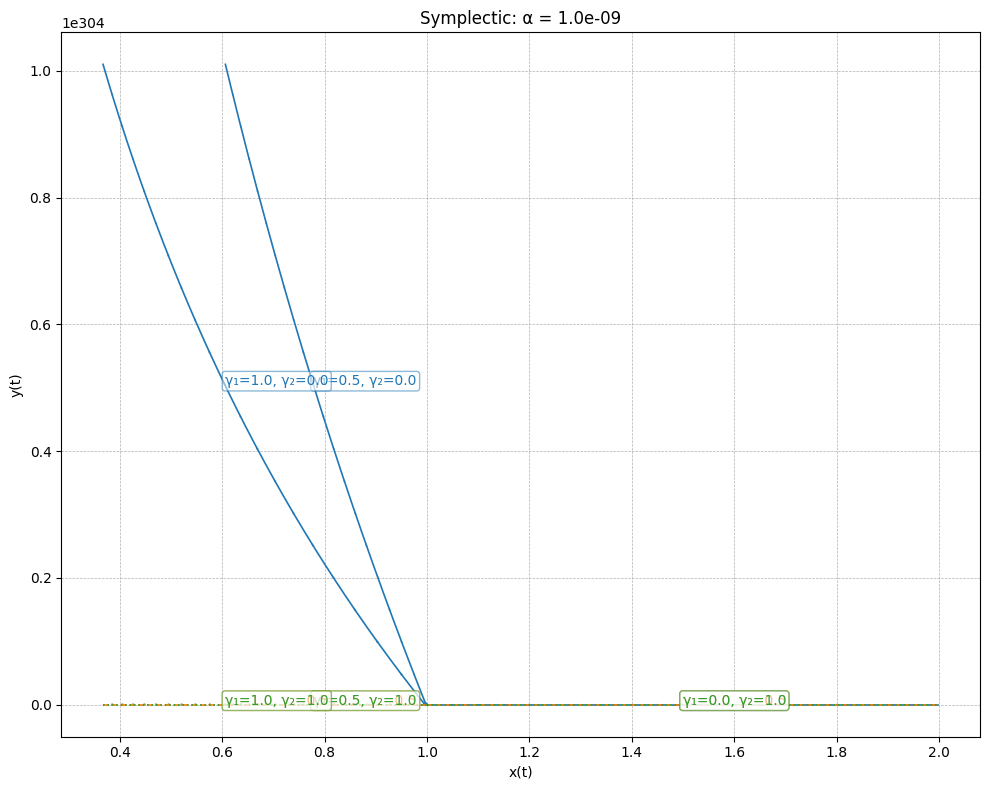

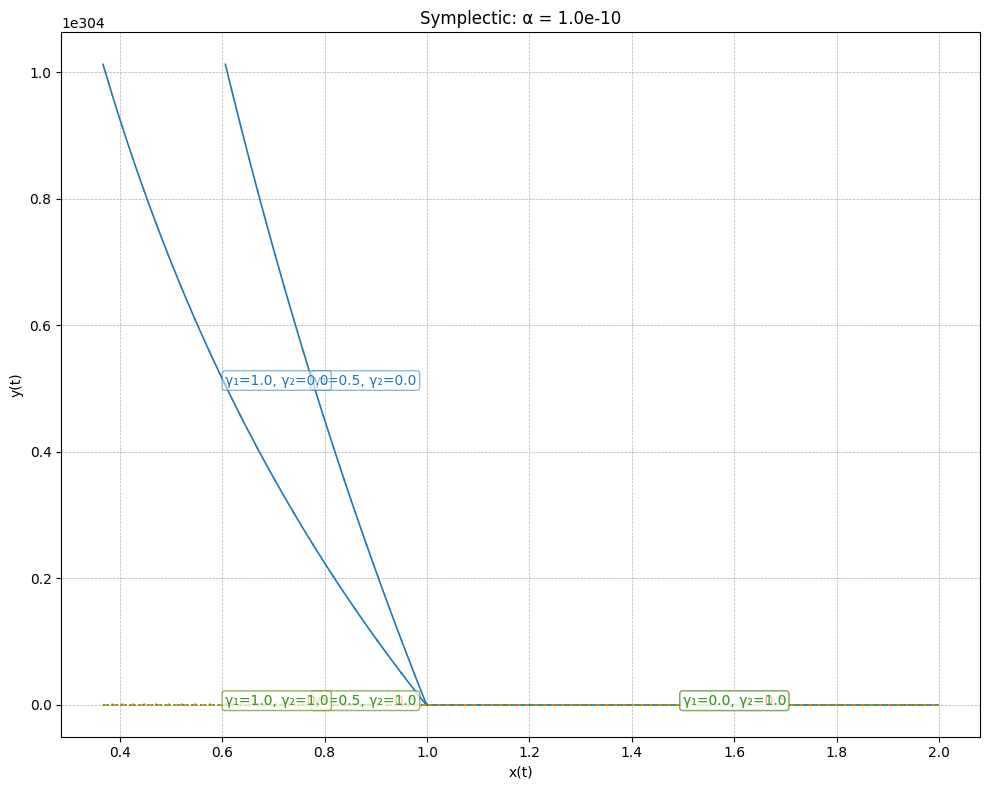

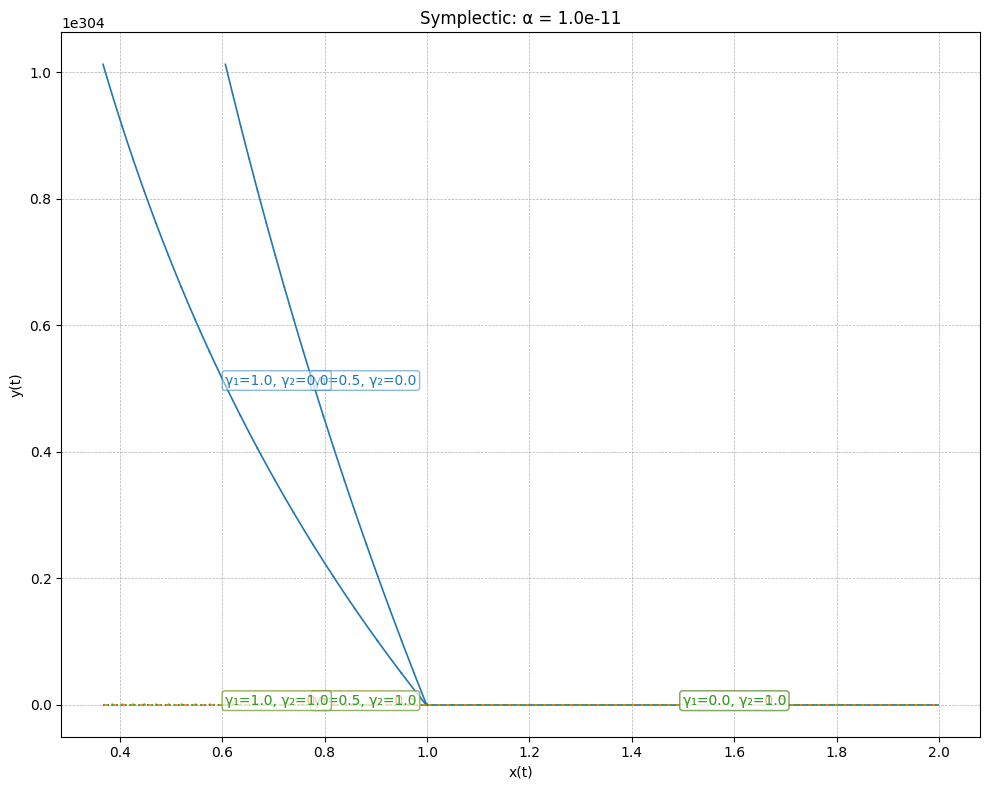

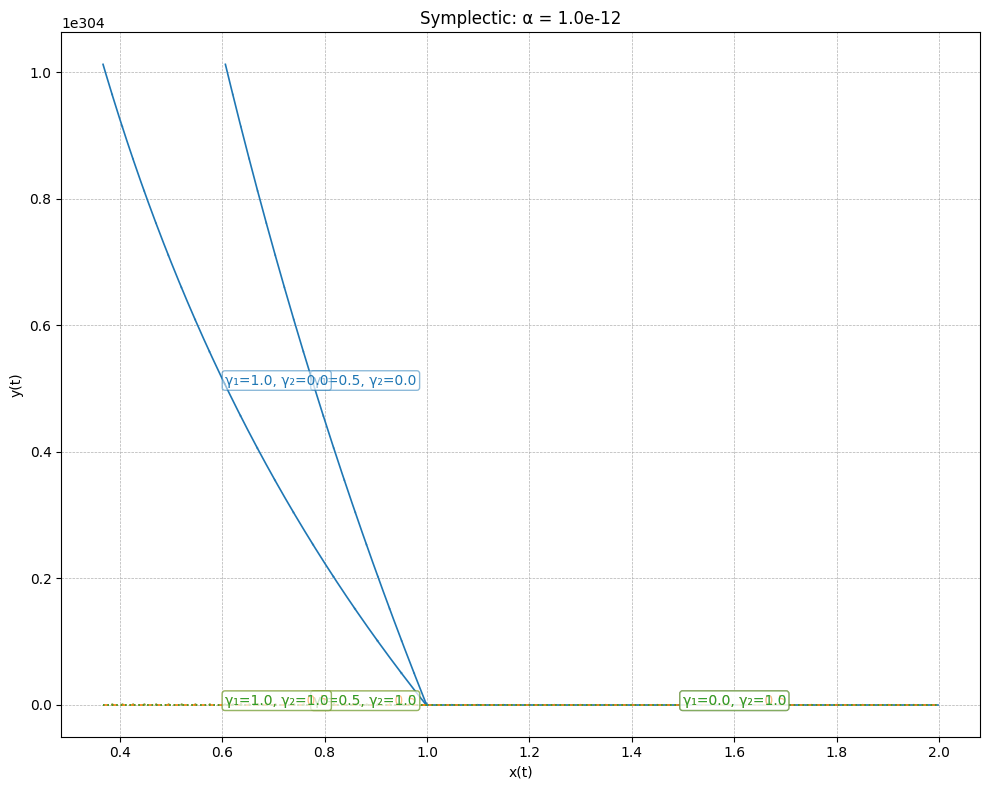

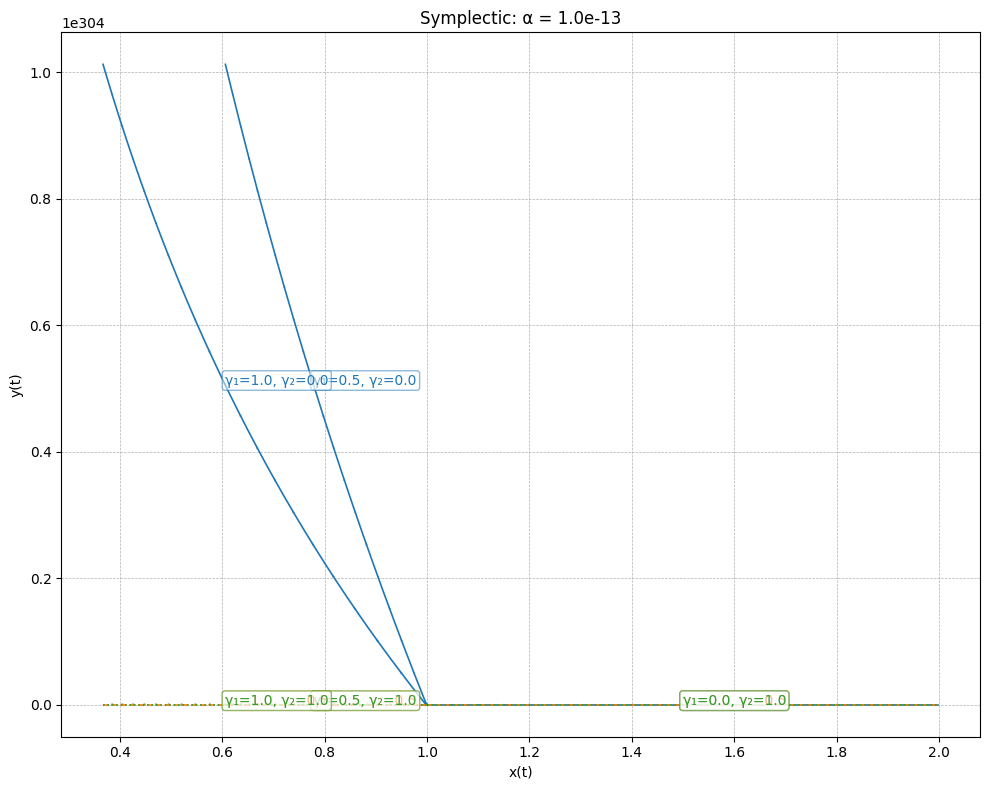

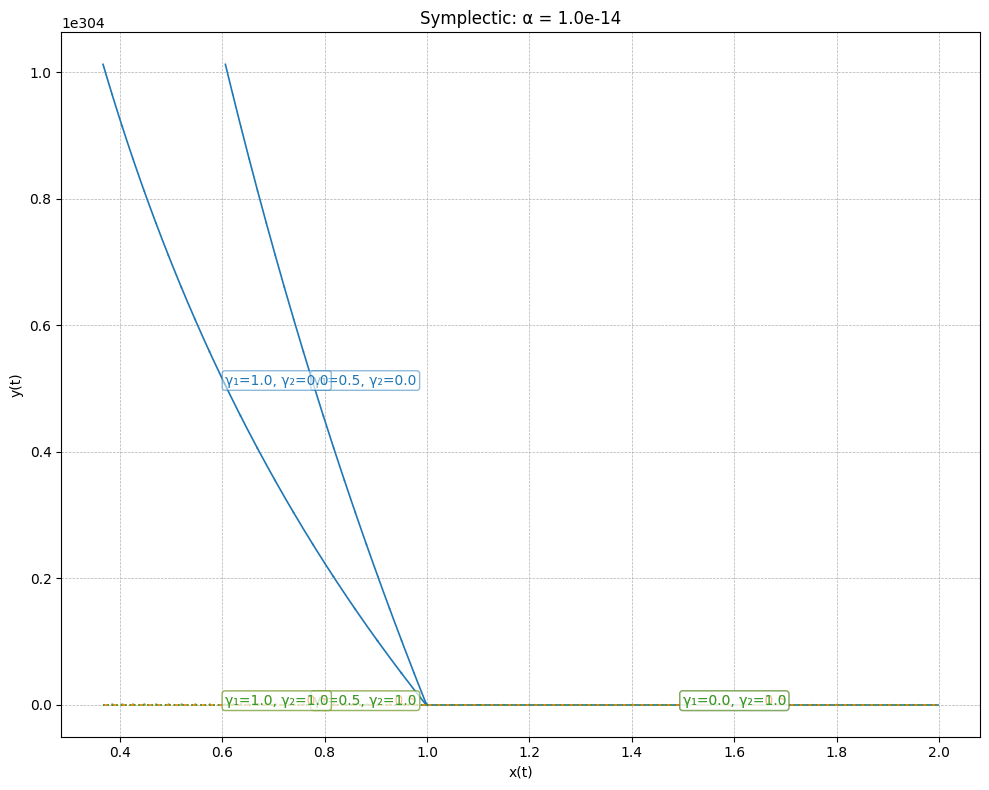

In [23]:
# Cell 3: Solve and plot per method and alpha with arrows and larger labels
for method in all_methods:
    print(f"Method: {method}")
    for alpha in alpha_list:
        plt.figure(figsize=(10, 8))
        fail_count = 0
        for gamma1 in gamma_1_list:
            for gamma2 in gamma_2_list:
                rhs, x0, y0 = get_rhs_system(alpha, K, gamma1, gamma2)
                try:
                    # Solve system
                    if method == 'Symplectic':
                        dt = t_eval[1] - t_eval[0]
                        x_vals, y_vals = [x0], [y0]
                        for t_i in t_eval[:-1]:
                            dx, dy = rhs(t_i, [x_vals[-1], y_vals[-1]])
                            x_vals.append(x_vals[-1] + dt * dx)
                            y_vals.append(y_vals[-1] + dt * dy)
                        x_vals = np.array(x_vals)
                        y_vals = np.array(y_vals)
                    else:
                        sol = solve_ivp(rhs, [0, t_end], [x0, y0], t_eval=t_eval, method=method)
                        x_vals, y_vals = sol.y[0], sol.y[1]
                    # Determine style group by gamma2
                    if gamma2 == 0:
                        grp = 'zero'
                    elif gamma2 == 0.5:
                        grp = 'half'
                    else:
                        grp = 'one'
                    style = group_styles[grp]
                    # Plot curve
                    plt.plot(x_vals, y_vals,
                             color=style['color'],
                             linestyle=style['linestyle'],
                             linewidth=1.2)
                    # Add arrows along trajectory
                    skip = max(5, len(x_vals)//20)
                    dx = np.gradient(x_vals[::skip])
                    dy = np.gradient(y_vals[::skip])
                    plt.quiver(x_vals[::skip], y_vals[::skip], dx, dy,
                               angles='xy', scale_units='xy', scale=5,
                               color=style['color'], alpha=0.7, width=0.003)
                    # Inline label at midpoint with larger fontsize
                    mid = len(x_vals) // 2
                    label_text = f"γ₁={gamma1:.1f}, γ₂={gamma2:.1f}"
                    plt.text(x_vals[mid], y_vals[mid], label_text,
                             fontsize=10, color=style['color'],
                             bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=style['color'], alpha=0.5))
                except Exception:
                    fail_count += 1
        if fail_count == len(gamma_1_list) * len(gamma_2_list):
            alpha_failed[method].append(alpha)
        plt.xlabel('x(t)')
        plt.ylabel('y(t)')
        plt.title(f"{method}: α = {alpha:.1e}")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

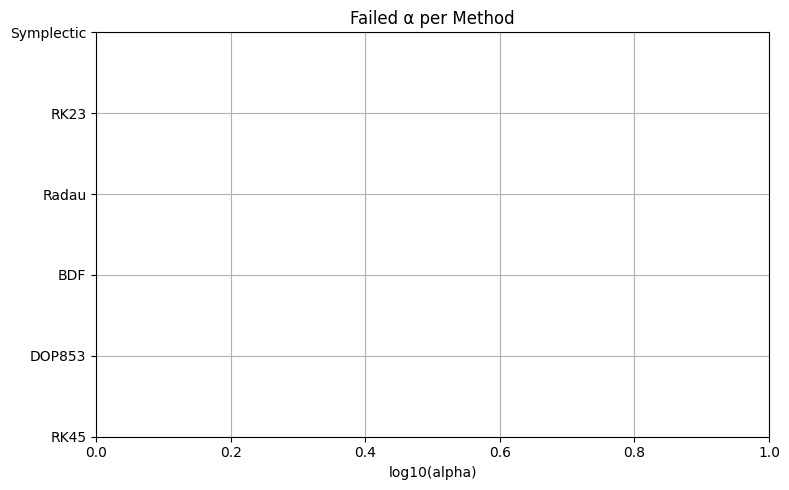

In [22]:
# Cell 4: Plot failures
plt.figure(figsize=(8, 5))
for method in all_methods:
    if alpha_failed[method]:
        plt.scatter(np.log10(alpha_failed[method]), [all_methods.index(method)] * len(alpha_failed[method]), label=method)
plt.yticks(range(len(all_methods)), all_methods)
plt.xlabel('log10(alpha)')
plt.title('Failed α per Method')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧬📉 Анализ фазового пространства генрегуляторной системы — обновлённая версия

- **Цель**: Изучить фазовую динамику, бифуркации и чувствительность решений системы ОДУ, моделирующей генрегуляцию:  
  $$
  \frac{dx}{dt} = \frac{K \cdot x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}, \quad
  \frac{dy}{dt} = \frac{K \cdot y^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}
  $$

- **Фиксированные параметры**:  
  - $b = 1.0$  
  - $K = 1.0$ (фиксированный скалярный множитель)  

- **Начальные условия**: Несколько точек около $b$:  
  $$
  x_0, y_0 \approx b \times (1 - \epsilon), \quad \epsilon \in \{10^{-7}, 10^{-8}, 10^{-9}\}
  $$  
  для исследования чувствительности и возможности нескольких траекторий решения.

- **Временной интервал**:  
  $$
  t \in [0, t_{\text{end}}], \quad t_{\text{end}} = 0.05
  $$

- **Диапазон альфа** (логарифмический масштаб, суженный):  
  $$
  \alpha \in \{10^{-9}, 10^{-10}, 10^{-11}, 10^{-12}, 10^{-13}, 10^{-14}\}
  $$

## ⚙️ Используемые численные решатели
- ⚡ `RK45` — явный метод Рунге-Кутты 4(5) с адаптивным шагом  
- 🌐 `DOP853` — высокопорядковый метод Dormand-Prince 8(5,3)  
- 🧱 `BDF` — метод обратных разностей, для жёстких систем  
- 🧿 `Radau` — A-устойчивый неявный метод Рунге-Кутты  
- 🐢 `RK23` — явный метод Рунге-Кутты 2(3), пониже порядок  
- 🌀 `Symplectic` — собственная реализация явного метода Эйлера (симплектический аналог)

## 📈 Визуализация и диагностика
- ✔️ Фазовые портреты ($y(t)$ против $x(t)$) для каждого решателя и каждого $\alpha$, на каждом графике показаны траектории для разных начальных условий.  
- ➡️ Стрелки (quiver) вдоль траекторий показывают направление потока — размер стрелок подобран для наглядности без засорения.  
- 🔄 Цвета, стили линий, маркеры используются для различения начальных условий; значения начальных условий подписаны прямо на кривых.  
- ⚠️ Учёт и логирование численных ошибок и сбоев для каждого решателя и $\alpha$.  
- 📊 Итоговая таблица по решателям с:  
  - Общим временем интегрирования  
  - Числом вычислений функции правой части (`nfev`), отражающим вычислительные затраты.

## 🧪 Расширенный численный анализ
- 🔍 **Оценка показателя Ляпунова**:  
  Приблизительный расчёт на основе расходимости близких траекторий.  
  Положительный показатель говорит о чувствительной зависимости и потенциальном хаосе.  
- 🌪️ **Обнаружение бифуркации Неймарк–Сакера**:  
  - Оценка отображения Пуанкаре (конечная точка решения)  
  - Якобиан, вычисленный численно по разностям начальных условий  
  - Анализ собственных чисел для выхода за единичную окружность (бифуркация).

## 📌 Примечания по реализации
- Начальные условия варьируются вблизи $b$ для проверки множественности решений и чувствительности.  
- Управление переполнением реализовано через ограничение экспонент в логарифмической области для предотвращения `NaN`/`Inf`.  
- Симплектический решатель — упрощённый явный метод Эйлера, поскольку в SciPy нет нативного симплектического метода.  
- Ошибки и неудачи интегрирования собираются и визуализируются в зависимости от $\alpha$, что помогает локализовать проблемные зоны параметра.

---

*Данный ноутбук даёт основу для исследования сложной динамики генрегуляторных ОДУ-систем, включая численную устойчивость, бифуркационный анализ и выявление хаоса с помощью множества решателей и перебора параметров.*